# Simple approach to clustering S&P 500 stocks

Some boilerplate imports.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Download daily closing prices for each S&P500 security.
Once this is done, fix a timespan (e.g. 3 years) to create a {trading days in 3 years}-dimensional vector for each security. Call this dimension $n$ from now on.
The following step would be to normalize the price of each security over this span. What is the wisest way to normalize?
1. Scale so that each vector has the same norm in $\ell^p$ for some $1 \le p \le \infty$.
2. Moving average normalization over 5, 10, 20, 50, etc. days.
3. A norm as in 1. but with unequal weights applied to different days.
4. Normalization used in El Mehdi's link: https://www.sciencedirect.com/science/article/pii/S1057521923001734

### Pulling daily closing prices from Yahoo Finance or loading them from pickle

Each time series is downloaded as a pandas Series, then stored in a list to be concatenated into a massive table.

The columns are tickers and the rows are dates. We remove any dates with missing data, but I'm sure there's a simple & effective imputation method (e.g. mean of last available and next available closing price).

In [2]:
# Create a list to store individual stock DataFrames
def yahoo_download(ticks):
    """
    yahoo_download downloads the tickers in ticks and stores them in a dataframe.
    """
    # Fetch the list of S&P 500 tickers from Wikipedia
    df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    tickers = df['Symbol'].tolist()
    
    equities = []
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, period = '3y')['Adj Close']
            stock_data.name = ticker  # Rename the Series to match the ticker
            equities.append(stock_data)
        except Exception as e:
            print(f"Failed to download data for {ticker}: {e}")

    # Concatenate all the individual DataFrames
    closing_prices = pd.concat(equities, axis=1)
    return closing_prices

# Read pickle file if exists, otherwise download stocks from Yahoo Finance
try:
    closing_prices = pd.read_pickle("./closing_prices_SP500.pkl")
except FileNotFoundError:
    closing_prices = yahoo_download(tickers)

# Drop rows with any missing values for consistency
closing_prices.dropna(axis=1, inplace=True)
closing_prices.to_pickle("./closing_prices_SP500.pkl")


## Data preprocessing

### Compute $\ell^2$ norm for each time series, then normalize by this norm

In [3]:
norms = {}
for ticker in closing_prices.columns:
    norms[ticker] = np.linalg.norm(closing_prices[ticker])

Next, we normalize each column in closing_prices. ```np.linalg.norm()``` is what I want.

In [4]:
closing_prices_normalized = closing_prices.copy()
for ticker in closing_prices.columns:
    closing_prices_normalized[ticker] = closing_prices[ticker]/norms[ticker]

For the clustering to work properly, the tickers need to denote rows instead of columns.

In [5]:
df_transposed = closing_prices_normalized.T

In [6]:
df_transposed

Date,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,...,2023-10-04,2023-10-05,2023-10-06,2023-10-09,2023-10-10,2023-10-11,2023-10-12,2023-10-13,2023-10-16,2023-10-17
MMM,0.038797,0.039117,0.038710,0.039062,0.038854,0.038021,0.036847,0.036275,0.036264,0.036602,...,0.022810,0.022761,0.022909,0.023077,0.023489,0.023425,0.023070,0.022982,0.023308,0.023466
AOS,0.029534,0.029625,0.029453,0.029507,0.029518,0.028980,0.028497,0.027653,0.028830,0.027918,...,0.037575,0.037478,0.038170,0.038930,0.039288,0.040326,0.039668,0.039855,0.040785,0.040746
ABT,0.033946,0.034046,0.033283,0.034398,0.033867,0.034247,0.034115,0.033437,0.032991,0.033025,...,0.031476,0.031657,0.031881,0.031841,0.032105,0.030486,0.029844,0.030069,0.030502,0.030489
ABBV,0.021228,0.021213,0.020870,0.021228,0.021235,0.021130,0.020825,0.020266,0.020311,0.021427,...,0.041706,0.041638,0.041861,0.042107,0.042045,0.042172,0.042298,0.042201,0.041992,0.042548
ACN,0.026975,0.027470,0.027793,0.027201,0.027387,0.026139,0.026309,0.025508,0.025806,0.025862,...,0.038297,0.038330,0.038643,0.038621,0.038659,0.038847,0.037830,0.037516,0.037952,0.038314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.028225,0.028234,0.028753,0.028979,0.029394,0.028791,0.028440,0.027589,0.027554,0.027087,...,0.037844,0.037326,0.036597,0.036429,0.036876,0.036266,0.035614,0.035807,0.036288,0.036591
ZBRA,0.026388,0.026683,0.026415,0.027234,0.027488,0.026708,0.026181,0.025812,0.026425,0.025671,...,0.020901,0.020141,0.020259,0.020144,0.020128,0.019654,0.019085,0.018727,0.019456,0.019277
ZBH,0.037401,0.037374,0.037353,0.037677,0.037588,0.036745,0.036505,0.035128,0.035251,0.034793,...,0.030423,0.030315,0.030761,0.030700,0.031116,0.029219,0.028490,0.028928,0.029136,0.029563
ZION,0.020498,0.020701,0.020389,0.021875,0.022519,0.022017,0.021081,0.020756,0.021407,0.021888,...,0.024929,0.024981,0.025198,0.025407,0.026268,0.026664,0.026327,0.025856,0.026866,0.027479


### Find most effective number of clusters

In [7]:
wcss = [] # WCSS is a measure of cluster spread: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_transposed)
    wcss.append(kmeans.inertia_) #inertia is the WCSS score

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Wi

We plot the spread of each cluster, and use the elbow method to find the best ```n_clusters```.

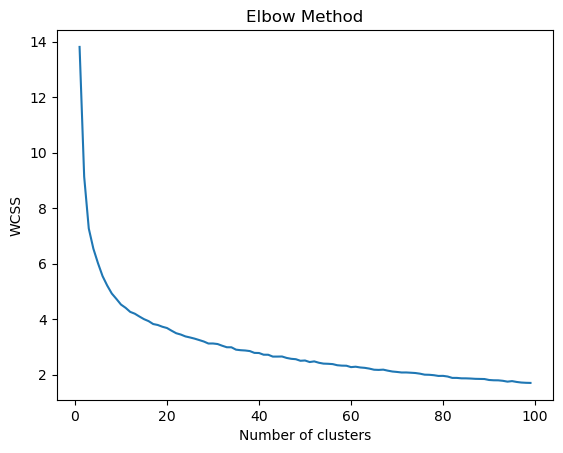

In [8]:
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Perform the actual clustering.

In [9]:
kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df_transposed)

C:\Users\safibn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## Add the clusters as a feature so that we may analyze the results

In [10]:
df_transposed['Cluster'] = pred_y

In [11]:
ticks = list(df_transposed.index)

In [12]:
clust = np.array([df_transposed.loc[x]["Cluster"] for x in ticks])

In [13]:
arrays = [
    clust,
    ticks
]

In [14]:
df_transposed.columns

Index([2020-10-19 00:00:00, 2020-10-20 00:00:00, 2020-10-21 00:00:00,
       2020-10-22 00:00:00, 2020-10-23 00:00:00, 2020-10-26 00:00:00,
       2020-10-27 00:00:00, 2020-10-28 00:00:00, 2020-10-29 00:00:00,
       2020-10-30 00:00:00,
       ...
       2023-10-05 00:00:00, 2023-10-06 00:00:00, 2023-10-09 00:00:00,
       2023-10-10 00:00:00, 2023-10-11 00:00:00, 2023-10-12 00:00:00,
       2023-10-13 00:00:00, 2023-10-16 00:00:00, 2023-10-17 00:00:00,
                 'Cluster'],
      dtype='object', name='Date', length=755)

In [15]:
df = pd.DataFrame(df_transposed.T.values, index=df_transposed.columns, columns = arrays)

In [16]:
df = df.iloc[:-1]

In [17]:
import seaborn as sns
data=df.stack(level=[0,1]).reset_index(name='value')
data.head(10)

,Date,level_1,level_2,value
0,2020-10-19,0.0,AIZ,0.028979
1,2020-10-19,0.0,AVB,0.025373
2,2020-10-19,0.0,BX,0.018801
3,2020-10-19,0.0,CBRE,0.020911
4,2020-10-19,0.0,CPT,0.024640
5,2020-10-19,0.0,EQR,0.024293
6,2020-10-19,0.0,ESS,0.025325
7,2020-10-19,0.0,EW,0.032167
8,2020-10-19,0.0,EXR,0.024110
9,2020-10-19,0.0,F,0.019187


<AxesSubplot:xlabel='Date', ylabel='value'>

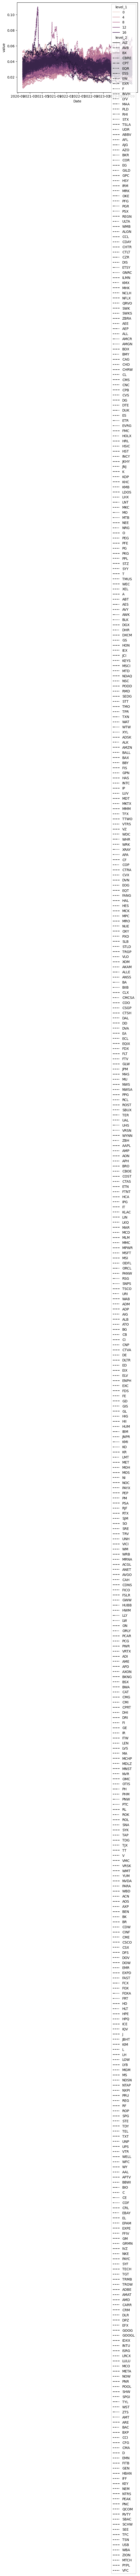

In [18]:
sns.lineplot(data=df.stack(level=[0,1]).reset_index(name='value'),
             x='Date', y='value', hue='level_1', style='level_2' 
            )

Behold the clusters:

In [19]:
# Checking the tickers in each cluster
for i in range(20):  # 20 is the number of clusters
    print(f"Cluster {i}: \n {df_transposed[df_transposed['Cluster'] == i].index.tolist()}")
    print()

Cluster 0: 
 ['AIZ', 'AVB', 'BX', 'CPT', 'CBRE', 'EW', 'EQR', 'ESS', 'EXR', 'F', 'INVH', 'LYV', 'MAA', 'PLD', 'RHI', 'STX', 'TSLA', 'UDR']

Cluster 1: 
 ['ABBV', 'AFL', 'AJG', 'AZO', 'BKR', 'COR', 'EG', 'GPC', 'GILD', 'HSY', 'IRM', 'MRK', 'OKE', 'PSX', 'PFG', 'PGR', 'REGN', 'ULTA', 'WMB']

Cluster 2: 
 ['ALGN', 'CZR', 'KMX', 'CCL', 'CTLT', 'CDAY', 'CHTR', 'DIS', 'ETSY', 'GNRC', 'ILMN', 'MHK', 'NFLX', 'NCLH', 'QRVO', 'SWKS', 'SWK', 'ZBRA']

Cluster 3: 
 ['LNT', 'ALL', 'MO', 'AMCR', 'AEE', 'AEP', 'AMGN', 'T', 'BDX', 'BMY', 'CHRW', 'CPB', 'CNC', 'CHD', 'CMS', 'CL', 'CAG', 'STZ', 'CVS', 'DG', 'DTE', 'DUK', 'ETR', 'EVRG', 'ES', 'FMC', 'HSIC', 'HOLX', 'HRL', 'HST', 'INCY', 'JKHY', 'JNJ', 'K', 'KDP', 'KMB', 'KHC', 'LHX', 'LDOS', 'MTB', 'MKC', 'NEE', 'NRG', 'PKG', 'PFE', 'PPL', 'PG', 'PEG', 'O', 'SYY', 'TMUS', 'WEC', 'XEL']

Cluster 4: 
 ['ABT', 'AES', 'A', 'AWK', 'AVY', 'BLK', 'DHR', 'DXCM', 'GS', 'HON', 'IEX', 'PODD', 'JCI', 'KEYS', 'MTD', 'MSCI', 'NDAQ', 'NSC', 'DGX', 'RMD', 'SEDG', 'STT', 